In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [8]:
size = 10
x1_min, x1_max = -size, size
x2_min, x2_max = -size, size
# major_ticks = np.arange(-size, size, size/10)
# minor_ticks = np.arange(-size, size, size/50)
step = size/100

colorizer = lambda x, y: ((size-y)/(size*2), (size+y)/(size*2), (size+x)/(size*2))

def plot_grid(x,y, colors, *, s=1):
    # plot the grid
    plt.figure()
    # plt.xlim(x1_min, x1_max)
    # plt.ylim(x2_min, x2_max)
    # plt.xticks(major_ticks)
    # plt.xticks(minor_ticks, minor=True)
    # plt.yticks(major_ticks)
    # plt.yticks(minor_ticks, minor=True)
    # plt.grid(True, which='minor', alpha=0.2)
    # plt.grid(True, which='major', alpha=0.5)
    plt.scatter(x, y, s=s, c=colors, edgecolor="none")
    plt.show()


,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
x1,-10.0,-9.9,-9.8,-9.7,-9.6,-9.5,-9.4,-9.3,-9.2,-9.1,...,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9
x2,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,...,9.9,9.9,9.9,9.9,9.9,9.9,9.9,9.9,9.9,9.9


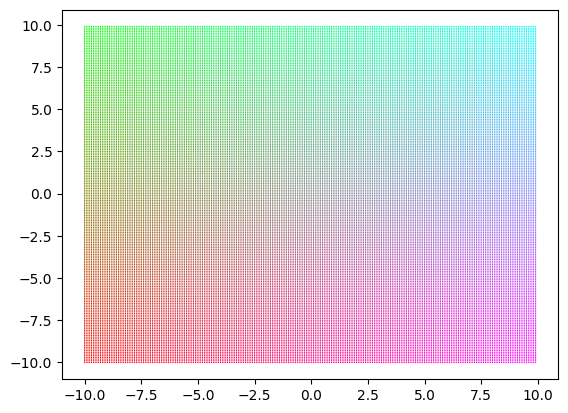

In [9]:
# xx = torch.meshgrid(torch.arange(x1_min, x1_max+step, step, dtype=torch.float32), torch.arange(x2_min, x2_max+step, step, dtype=torch.float32))

x1 = np.arange(x1_min, x1_max, step)
x2 = np.arange(x2_min, x2_max, step)
xx = np.meshgrid(x1, x2)
xx = np.array([x.flatten() for x in xx])
xx = torch.tensor(xx)

display(pd.DataFrame(xx.T, columns=["x1", "x2"]).T)

# # circle shape dots
# radius = 4
# # remove points outside the circle
# mask = np.sqrt(xx[0]**2 + xx[1]**2) <= radius
# # apply the mask to the meshgrid
# xx = np.where(mask, xx[0], np.nan), np.where(mask, xx[1], np.nan)
# print(xx[0].shape, xx[1].shape)
# # remove nan values from the meshgrid
# xx = np.array([x[~np.isnan(x)] for x in xx])
# print(xx[0].shape, xx[1].shape)

# Map grid coordinates to colors
colors = list(map(colorizer, xx[0], xx[1]))
plot_grid(xx[0], xx[1], colors)

In [19]:
import typing


def round_ste(x: torch.Tensor):
    """
    Implement Straight-Through Estimator for rounding operation.
    """
    return (x.round() - x).detach() + x


CLIPMIN = 1e-5
CLIPMAX = 1e4


def quant_dequant(
    x: torch.Tensor,
    # scale: float,
    *,
    n_bits: int = 4,
    symmetric: bool = False,
    non_linear_fn: tuple[
        typing.Callable[
            [torch.Tensor, typing.Tuple[typing.Any, ...], typing.Any],
            torch.Tensor,
        ],
        typing.Callable[
            [torch.Tensor, typing.Tuple[typing.Any, ...], typing.Any],
            torch.Tensor,
        ],
    ] = None,
):
    xmin = x.amin([-1], keepdim=True)
    xmax = x.amax([-1], keepdim=True)

    if symmetric:
        abs_max = torch.max(xmax.abs(), xmin.abs())
        scale = abs_max / (2 ** (n_bits - 1) - 1)
        scale = scale.clamp(min=CLIPMIN, max=CLIPMAX)
        zero_point = (2 ** (n_bits - 1) - 1) * torch.ones_like(scale)
    else:
        range = xmax - xmin  # gamma * max(W) - beta * min(W)
        scale = range / (2**n_bits - 1)  # (gamma * max(W) - beta * min(W)) / (2^bit-1)
        scale = scale.clamp(min=CLIPMIN, max=CLIPMAX)  # 최대 최소값 제한 1e-5 ~ 1e4
        zero_point = -(xmin) / (scale)  # -beta / h
    shift = zero_point.clamp(min=-1e4, max=1e4).round()  # round(-beta/h)

    x_quant = x
    if non_linear_fn is not None:
        x_quant = non_linear_fn[0](x_quant)

    x_quant = round_ste(x_quant / scale) + shift
    x_quant = x_quant.clamp(0, 2 ** (n_bits) - 1)

    x_dequant = x_quant
    x_dequant = (x_dequant - shift) * scale
    if non_linear_fn is not None:
        x_dequant = non_linear_fn[1](x_dequant)
    return x_dequant

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
x1,-10.613333,-9.286667,-9.286667,-9.286667,-9.286667,-9.286667,-9.286667,-9.286667,-9.286667,-9.286667,...,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667
x2,-10.613333,-10.613333,-10.613333,-10.613333,-10.613333,-10.613333,-10.613333,-10.613333,-10.613333,-10.613333,...,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667,9.286667


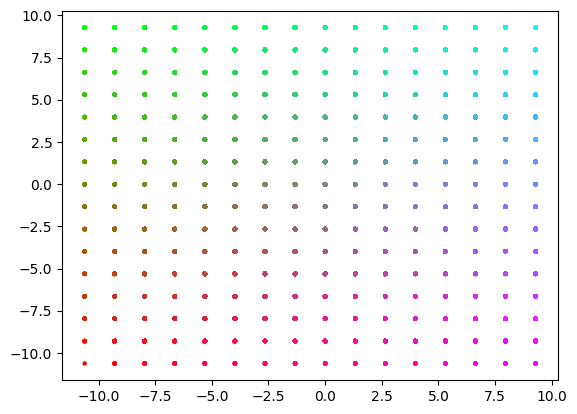

In [20]:
yy = quant_dequant(
    xx,
    #    scale=.1
)
display(pd.DataFrame(yy.T, columns=["x1", "x2"]).T)
plot_grid(yy[0], yy[1], colors, s=10)

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
x1,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,...,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938
x2,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,-18.679938,...,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938,18.679938


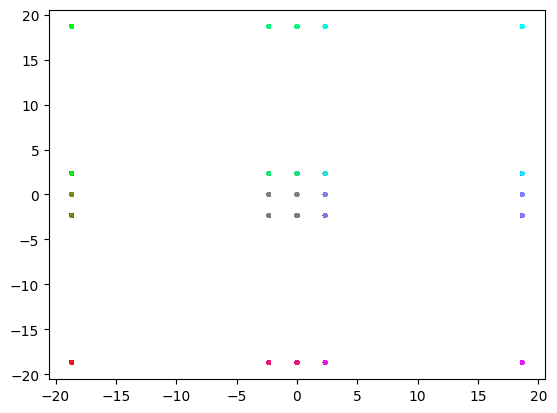

In [21]:
yy = quant_dequant(
    xx,
    # scale=0.1,
    non_linear_fn=(
        lambda x: (x.abs() ** (1 / 3)) * x.sign(),
        lambda x: (x.abs() ** 3) * x.sign(),
        # lambda x: (x ** (1 / 3)),
        # lambda x: (x ** 3),
    ),
)
display(pd.DataFrame(yy.T, columns=["x1", "x2"]).T)
plot_grid(yy[0], yy[1], colors, s=10)

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
x1,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,...,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297
x2,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,-14.201297,...,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297,14.201297


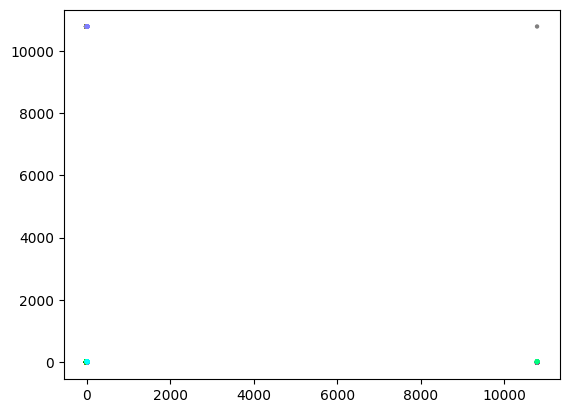

In [22]:
yy = quant_dequant(
    xx,
    # scale=0.1,
    non_linear_fn=(
        # lambda x: x.abs().log() * x.sign(),
        # lambda x: x.abs().exp() * x.sign(),
        lambda x: x.abs().log() * x.sign(),
        lambda x: x.abs().exp() * x.sign(),
    ),
)
display(pd.DataFrame(yy.T, columns=["x1", "x2"]).T)
plot_grid(yy[0], yy[1], colors, s=10)

In [25]:
# data = torch.normal(0, 5, (1, 100)).sort().values
data = torch.load("../layer_inps.pt")
data = data.sort().values
torch.set_printoptions(precision=4, sci_mode=False)

dequanted_data = quant_dequant(
    data,
    # scale=0.1,
    # non_linear_fn=(
    #     lambda x: x.abs().log() * x.sign(),
    #     lambda x: x.abs().exp() * x.sign(),
    # ),
)

display(data)
display(dequanted_data)
display(data - dequanted_data)

tensor([[  -449.2500,    -39.0000,    -30.5000,  ...,     12.5234,
             15.7578,    754.0000],
        [    -0.7881,     -0.4121,     -0.3679,  ...,      0.7480,
              0.8877,      1.0410],
        [    -0.5107,     -0.3606,     -0.3381,  ...,      0.4136,
              0.4829,      0.6035],
        ...,
        [    -0.6606,     -0.4902,     -0.3735,  ...,      0.6191,
              0.7114,      1.1045],
        [    -0.4062,     -0.3530,     -0.3433,  ...,      0.4719,
              0.8569,      0.9160],
        [    -0.6152,     -0.3206,     -0.3127,  ...,      0.7119,
              0.8154,      0.8574]])

tensor([[  -481.3000,      0.0000,      0.0000,  ...,      0.0000,
              0.0000,    721.9500],
        [    -0.7316,     -0.3658,     -0.3658,  ...,      0.7316,
              0.8536,      1.0975],
        [    -0.5200,     -0.3714,     -0.3714,  ...,      0.4457,
              0.5200,      0.5943],
        ...,
        [    -0.7061,     -0.4707,     -0.3530,  ...,      0.5884,
              0.7061,      1.0591],
        [    -0.4408,     -0.3526,     -0.3526,  ...,      0.4408,
              0.8815,      0.8815],
        [    -0.5891,     -0.2945,     -0.2945,  ...,      0.6872,
              0.7854,      0.8836]])

tensor([[    32.0500,    -39.0000,    -30.5000,  ...,     12.5234,
             15.7578,     32.0500],
        [    -0.0564,     -0.0463,     -0.0021,  ...,      0.0164,
              0.0341,     -0.0564],
        [     0.0092,      0.0108,      0.0333,  ...,     -0.0321,
             -0.0371,      0.0092],
        ...,
        [     0.0454,     -0.0195,     -0.0205,  ...,      0.0308,
              0.0054,      0.0454],
        [     0.0345,     -0.0004,      0.0093,  ...,      0.0312,
             -0.0246,      0.0345],
        [    -0.0262,     -0.0260,     -0.0182,  ...,      0.0247,
              0.0300,     -0.0262]])